# 0 installing necessary modules

In [1]:

!pip install --upgrade pip
!pip install torch torchvision numpy opencv-python requests pillow grad-cam


# 1. Importing necessary modules

In [2]:
import torchvision
import warnings
import torch
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from PIL import Image

## 1.1 importing modules from pytorch_grad_cam

In [3]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

### 1.1.1 importing modules for visualisation

In [4]:
from pytorch_grad_cam.grad_cam_plusplus import GradCAMPlusPlus
from pytorch_grad_cam.eigen_cam import EigenCAM
from pytorch_grad_cam.score_cam import ScoreCAM
from pytorch_grad_cam.xgrad_cam import XGradCAM
from pytorch_grad_cam import GradCAM

# 2. Defining necessary functions

In [81]:
def image_transform(image_url):
    img = np.array(Image.open(requests.get(image_url, stream=True).raw))
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return img,input_tensor

In [82]:
def predict_and_get_target_class(model, input_tensor):
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = [torch.argmax(output).item()]
    return predicted_class

In [83]:
def find_last_conv_layer(model):
    for layer in reversed(list(model.modules())):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    return None

In [84]:
def get_last_conv_layer(model_name):
    conv_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d)]
    print(f'There are {len(conv_layers)} conv2d layers in this network')
    input_layer=int(input(f'There are {len(conv_layers)} conv2d layers in this network, which layer you want to visualize?'))
    if int(input_layer)<=0:
        return print('PLease enter proper positive interger number')
    else:
        return conv_layers[input_layer-1]

# 3. importing image and model

In [85]:
model = models.densenet121(pretrained=True)
#model.eval()

In [86]:
image_url='https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg'
img,input_tensor=image_transform(image_url)

### 3.1.1 making prediction with the model

In [87]:
predict_and_get_target_class(model,input_tensor)

[463]

### 3.1.2 saving the target label number

In [88]:
targets =[ClassifierOutputTarget(predict_and_get_target_class(model, input_tensor))]

### 3.1.3 getting the convolutional layer

In [89]:
target_layers = [get_last_conv_layer(model)]

There are 120 conv2d layers in this network


# 4. appling the gradcam methods

## 4.1 normal grad cam

In [90]:

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    grad_cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

## 4.2 GradCAM++

In [91]:
cam2=GradCAMPlusPlus(model=model, target_layers=target_layers)
grayscale_cams2=cam2(input_tensor=input_tensor)
grayscale_cam2 = grayscale_cams2[0, :]
gradcamplusplus_image=show_cam_on_image(img,grayscale_cam2,use_rgb=True)


## 4.3 EigenCAM

In [92]:
cam3=EigenCAM(model=model,target_layers=target_layers)
grayscale_cams3=cam3(input_tensor=input_tensor)
grayscale_cam3=grayscale_cams3[0, :]
eigencam_image=show_cam_on_image(img,grayscale_cam3,use_rgb=True)

## 4.4 ScoreCAM

In [93]:
'''cam4=ScoreCAM(model=model,target_layers=target_layers)
grayscale_cams4=cam4(input_tensor=input_tensor)
grayscale_cam4=grayscale_cams4[0, :]
cam4_image=show_cam_on_image(img,grayscale_cam4,use_rgb=True)'''

'cam4=ScoreCAM(model=model,target_layers=target_layers)\ngrayscale_cams4=cam4(input_tensor=input_tensor)\ngrayscale_cam4=grayscale_cams4[0, :]\ncam4_image=show_cam_on_image(img,grayscale_cam4,use_rgb=True)'

## 4.5 XGradCAM

In [94]:
cam5=XGradCAM(model=model,target_layers=target_layers)
grayscale_cams5=cam5(input_tensor=input_tensor)
grayscale_cam5=grayscale_cams5[0, :]
xgradcam_image=show_cam_on_image(img,grayscale_cam5,use_rgb=True)

# 5. visualizing

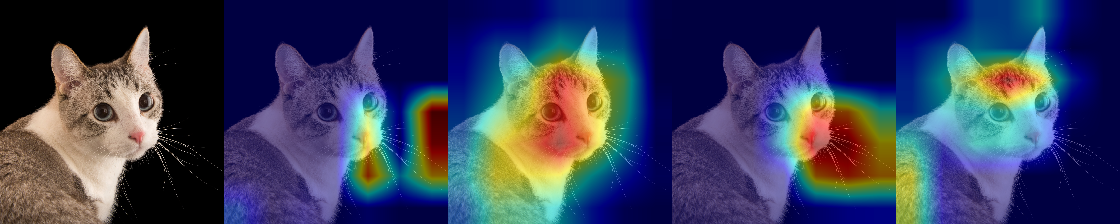

In [95]:
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
imagess = np.hstack((np.uint8(255*img), grad_cam_image, gradcamplusplus_image,eigencam_image,xgradcam_image))
Image.fromarray(imagess)